# Method: RNN 
# Dataset: KS Equation, L = 60
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("KS, L = 60", "../../data/ks60", 0.5)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 240)
Test size: (90000, 240)


**Create test set**

In [6]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [7]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 2000 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [8]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 240)
Test output size: (100, 400, 240)


# 2. RNN Implementation

In [9]:
def RNN(h_dim, data_dim, alpha = 1, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """

    def init_fun(rng):
        """
        This function initialize the weights of the RNN

        args:
        ====
         rng: jax RNG

        outputs:
        ======
         params: a tuple of parameters
        """

        k1, k2, k3, k4, k5 = jax.random.split(rng, num = 5)
        W_in   = W_init(k1, (h_dim, data_dim))  # data to internal-state
        W_out  = W_init(k2, (data_dim, h_dim))  # internal-state to output 
        W_h    = W_init(k3, (h_dim, h_dim))     # internal-state to internal-state
        h_bias = b_init(k4, (h_dim, ))
        W_bias = b_init(k5, (data_dim, ))

        params = (W_in, W_out, W_h, h_bias, W_bias)
        return params

    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state

        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)

        outputs:
        =======
         h_last: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        # extract parameters
        W_in, W_out, W_h, h_bias, W_bias = params

        # initial hidden state is set to zero
        h_zero = jnp.zeros((h_dim, ))

        # forward pass
        # RNN: internal function to process data
        def process_internal(hidden, x):
            h_new = (1-alpha)*hidden + alpha * jnp.tanh( W_h@hidden + W_in@x + h_bias)
            #out   = W_out@jnp.concatenate([h_new, jnp.tanh(x)])
            out   = x + W_out @ h_new + W_bias
            return h_new, out
        h_final, pred_traj = jax.lax.scan(process_internal, h_zero, time_series)

        return h_final, pred_traj[-1]

    def forecast(params, h_internal, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.

        args:
        ====
         params: tuple of parameters
         h_internal:
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction

        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        # extract parameters
        W_in, W_out, W_h, h_bias, W_bias = params

        # forward pass
        # RNN: internal function to process data
        def forecast_internal(pair_h_x, _ ):
            hidden, x = pair_h_x
            h_new = (1-alpha) * hidden + alpha * jnp.tanh( W_h @ hidden + W_in @ x + h_bias)
            out   = x + W_out @ h_new + W_bias
            return (h_new, out), out 
        _, pred_traj = jax.lax.scan(forecast_internal, (h_internal, x_input), None, length=horizon)

        # return the trajectory of predictions
        return pred_traj

    return init_fun, process, forecast

In [10]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 1.5):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
                
        loss_train_traj = []
        loss_train_all_traj = []
        
        best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test)[None,:]).astype(int) 
        x_val = data_test[t_past_batch_val]
        y_val = data_test[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 50):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if (best_mse < early_stopping_baseline or mse_val > 1000) and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize RNN
    init_fun, process, forecast = RNN(nn_size, data_dim)       # RNN Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [11]:
def get_test_pred(data_test, params, rnn_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = rnn_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Parameter tuning

There are 3 parameters to tune
- nn_size [100, 500, 1000, 1500] - size of the hidden layer
- L_forecast_train [4, 8, 16] - steps forward considered when calculating loss during training
- L_past [1, 8, 16] - length of time series used as input during training 

As a full grid search will be computationally expensive, nn_size is first tuned using a fixed L_forecast_train and L_past, then a grid search is performed on the optimal nn_size

## 3.1 nn_size

**Parameters**
- nn_size = [100, 500, 1000, 1500]
- L_forecast_train = 8
- L_past = 4

In [19]:
L_forecast_train = 8
L_past = 4
b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.1.1 nn_size = 100

In [20]:
nn_size = 100

In [21]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,)

Backpropogation start

Epoch 10: Time taken = 3.10 | Train loss = 0.0828148 | Val loss =  3822.8645020
Epoch 20: Time taken = 3.22 | Train loss = 0.0652355 | Val loss =  13460.9550781
Epoch 30: Time taken = 3.50 | Train loss = 0.0585431 | Val loss =  21755.4921875
EARLY STOPPING. Epoch 32: Train loss = 0.0574943 | Val loss =  22442.3125000
Best Validation MSE: 96.7591171
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 2.67 | Train loss = 0.0784758 | Val loss =  7254.1259766
Epoch 20: Time taken = 2.70 | Train loss = 0.0678674 | Val loss =  13490.1904297
Epoch 30: Time taken = 2.82 | Train loss = 0.0624308 | Val loss =  15049.5283203
EARLY STOPPING. Epoch 31: Train loss = 0.0616280 | Val loss =  15590.5908203
Best Validation MSE: 637.6583862

Epoch 10: Time taken = 3.37 | Train loss = 0.0748556 | Val loss =  8544.1845703
Epoch 20: Time taken = 2.55 | Train loss = 0.0657974 | Val loss =  10437.8251953
Epoch 30: Time taken = 3.52 | Train loss = 0.0588705 | Val loss =  26702.2753906
EARLY 

In [22]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_1_mu_preds.pkl")

Testing complete. Time taken: 0.54


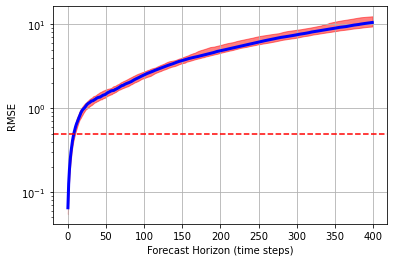

It takes around t = 2.00 for mean error to exceed 0.5


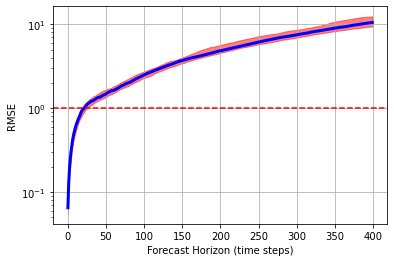

It takes around t = 5.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.974
Median NRMSE at t = 0.5: 1.482
Median NRMSE at t = 1: 2.507
Median NRMSE at t = 2: 4.850
Median NRMSE at t = 3: 7.525


In [23]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = 0.25)
res_single.plot_rmse(error_thresh = 1., dt = 0.25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 500

In [24]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

In [25]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 2.01 | Train loss = 0.0162741 | Val loss =  762.2996826
Epoch 20: Time taken = 2.14 | Train loss = 0.0047935 | Val loss =  289.8418579
Epoch 30: Time taken = 2.09 | Train loss = 0.0034696 | Val loss =  149.9170837
Epoch 40: Time taken = 2.04 | Train loss = 0.0028647 | Val loss =  24.7964916
Epoch 50: Time taken = 2.07 | Train loss = 0.0024977 | Val loss =  2.9495151
Epoch 52: Time taken = 2.16 | Train loss = 0.0024295 | Val loss =  2.5566609
Epoch 59: Time taken = 2.35 | Train loss = 0.0022721 | Val loss =  1.8396270
Epoch 60: Time taken = 2.30 | Train loss = 0.0021987 | Val loss =  1.9173473
Epoch 64: Time taken = 2.26 | Train loss = 0.0021594 | Val loss =  1.7032491
Epoch 70: Time taken = 2.33 | Train loss = 0.0020464 | Val loss =  2.0030763
Epoch 71: Time taken = 2.26 | Train loss = 0.0020317 | Val loss =  1.6805402
Epoch 77: Time taken = 2.48 | Train loss = 0.0018458 | Val loss =  1.6786902
Epoch 80: Time taken = 2.32 | Train loss = 0.0

In [26]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_2_mu_preds.pkl")

Testing complete. Time taken: 0.52


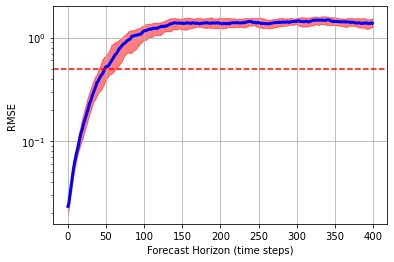

It takes around t = 12.25 for mean error to exceed 0.5


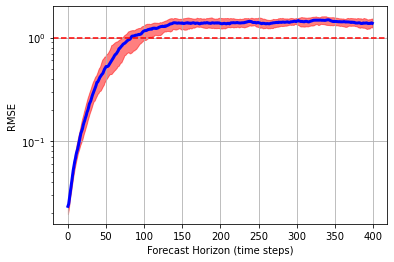

It takes around t = 20.75 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.141
Median NRMSE at t = 0.5: 0.524
Median NRMSE at t = 1: 1.159
Median NRMSE at t = 2: 1.364
Median NRMSE at t = 3: 1.436


In [27]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = 0.25)
res_single.plot_rmse(error_thresh = 1., dt = 0.25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 1000

In [28]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1000

In [29]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.17 | Train loss = 0.0050016 | Val loss =  1.8736430
Epoch 20: Time taken = 3.14 | Train loss = 0.0028136 | Val loss =  1.7204286
Epoch 30: Time taken = 3.13 | Train loss = 0.0022253 | Val loss =  1.6645043
Epoch 40: Time taken = 3.13 | Train loss = 0.0017556 | Val loss =  1.6564370
Epoch 50: Time taken = 3.12 | Train loss = 0.0016392 | Val loss =  1.6489954
Epoch 57: Time taken = 3.13 | Train loss = 0.0014719 | Val loss =  1.5965682
Epoch 60: Time taken = 3.12 | Train loss = 0.0014509 | Val loss =  1.6536177
Epoch 70: Time taken = 3.12 | Train loss = 0.0014388 | Val loss =  2.0776978
Epoch 80: Time taken = 3.11 | Train loss = 0.0013425 | Val loss =  1.7072632
Epoch 90: Time taken = 3.12 | Train loss = 0.0012459 | Val loss =  1.7315294
Epoch 95: Time taken = 3.12 | Train loss = 0.0011407 | Val loss =  1.5931566
Epoch 100: Time taken = 3.13 | Train loss = 0.0013674 | Val loss =  1.6575335
Epoch 109: Time taken = 3.12 | Train loss = 0.001234

In [30]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_3_mu_preds.pkl")

Testing complete. Time taken: 0.66


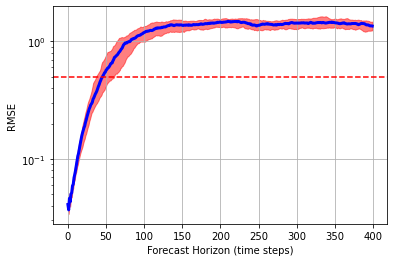

It takes around t = 11.50 for mean error to exceed 0.5


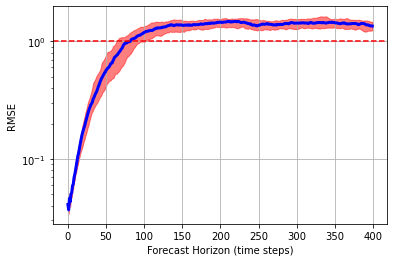

It takes around t = 20.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.174
Median NRMSE at t = 0.5: 0.569
Median NRMSE at t = 1: 1.191
Median NRMSE at t = 2: 1.459
Median NRMSE at t = 3: 1.432


In [31]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 1500

In [32]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [200, 200, 200]  # Number of epochs for each learning rate
nn_size = 1500

In [33]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 5.10 | Train loss = 0.0144884 | Val loss =  207.7120209
Epoch 20: Time taken = 5.13 | Train loss = 0.0061859 | Val loss =  3.9415119
Epoch 30: Time taken = 5.11 | Train loss = 0.0047522 | Val loss =  6.1367202
Epoch 40: Time taken = 5.12 | Train loss = 0.0029959 | Val loss =  31.1269150
Epoch 50: Time taken = 5.12 | Train loss = 0.0039585 | Val loss =  51.5975571
Epoch 60: Time taken = 5.12 | Train loss = 0.0034437 | Val loss =  330.4489441
Epoch 70: Time taken = 5.11 | Train loss = 0.0033550 | Val loss =  546.5898438
Epoch 80: Time taken = 5.13 | Train loss = 0.0038700 | Val loss =  744.9013062
EARLY STOPPING. Epoch 87: Train loss = 0.0026334 | Val loss =  1087.5255127
Best Validation MSE: 2.1602831
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 5.12 | Train loss = 0.0020456 | Val loss =  36.9955750
Epoch 20: Time taken = 5.10 | Train loss = 0.0016076 | Val loss =  119.1477127
Epoch 30: Time taken = 5.08 | Train loss = 0.0013547 | Val los

In [34]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_4_mu_preds.pkl")

Testing complete. Time taken: 0.78


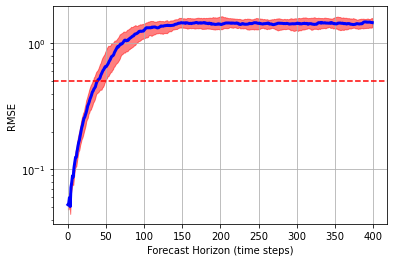

It takes around t = 9.75 for mean error to exceed 0.5


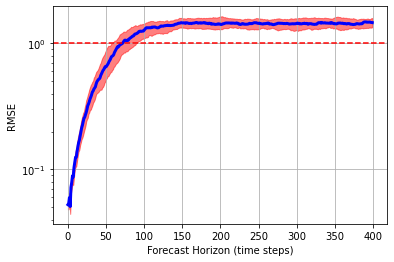

It takes around t = 18.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.240
Median NRMSE at t = 0.5: 0.653
Median NRMSE at t = 1: 1.277
Median NRMSE at t = 2: 1.419
Median NRMSE at t = 3: 1.446


In [35]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 L_forecast_train + L_past

**Parameters**
- nn_size = 1000
- L_forecast_train = [1, 8, 16]
- L_past = [4, 8, 16]

In [38]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.2.1 L_forecast_train = 4, L_past = 1

In [39]:
L_forecast_train = 4; L_past = 1

In [40]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.18 | Train loss = 0.0043427 | Val loss =  1549.5102539
Epoch 20: Time taken = 1.16 | Train loss = 0.0019485 | Val loss =  119.9182205
Epoch 30: Time taken = 1.34 | Train loss = 0.0013927 | Val loss =  4.1398344
Epoch 40: Time taken = 1.14 | Train loss = 0.0011335 | Val loss =  3.2354562
Epoch 50: Time taken = 1.32 | Train loss = 0.0009575 | Val loss =  2.7231448
Epoch 52: Time taken = 1.19 | Train loss = 0.0009275 | Val loss =  2.4173465
Epoch 60: Time taken = 1.28 | Train loss = 0.0008618 | Val loss =  2.4678729
Epoch 70: Time taken = 1.24 | Train loss = 0.0007625 | Val loss =  3.2615039
Epoch 80: Time taken = 1.27 | Train loss = 0.0007075 | Val loss =  3.0072854
Epoch 82: Time taken = 1.20 | Train loss = 0.0006895 | Val loss =  2.2850106
Epoch 84: Time taken = 1.20 | Train loss = 0.0006946 | Val loss =  2.2602277
Epoch 87: Time taken = 1.17 | Train loss = 0.0006615 | Val loss =  2.2473841
Epoch 88: Time taken = 1.18 | Train loss = 0.000

In [41]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_1_mu_preds.pkl")

Testing complete. Time taken: 0.47


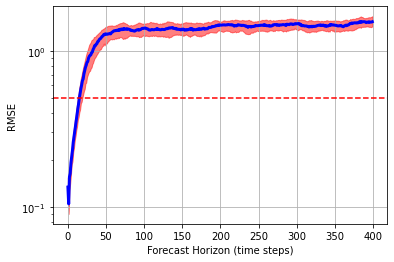

It takes around t = 4.00 for mean error to exceed 0.5


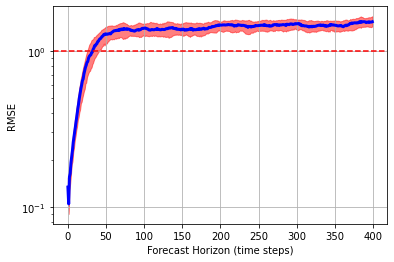

It takes around t = 8.25 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.661
Median NRMSE at t = 0.5: 1.276
Median NRMSE at t = 1: 1.399
Median NRMSE at t = 2: 1.464
Median NRMSE at t = 3: 1.494


In [42]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 L_forecast_train = 4, L_past = 4

In [43]:
L_forecast_train = 4; L_past = 4

In [44]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.96 | Train loss = 0.0116231 | Val loss =  11542.5488281
Epoch 20: Time taken = 1.64 | Train loss = 0.0072346 | Val loss =  7352.4038086
Epoch 30: Time taken = 1.80 | Train loss = 0.0028516 | Val loss =  3102.4035645
Epoch 40: Time taken = 1.63 | Train loss = 0.0017352 | Val loss =  1688.9689941
Epoch 50: Time taken = 1.65 | Train loss = 0.0012498 | Val loss =  1410.1254883
Epoch 54: Time taken = 1.71 | Train loss = 0.0011261 | Val loss =  1284.0288086
Epoch 56: Time taken = 1.69 | Train loss = 0.0010915 | Val loss =  1280.3406982
Epoch 58: Time taken = 1.73 | Train loss = 0.0010400 | Val loss =  1228.2890625
Epoch 59: Time taken = 1.72 | Train loss = 0.0010153 | Val loss =  1113.0034180
Epoch 60: Time taken = 1.72 | Train loss = 0.0010061 | Val loss =  1085.9162598
Epoch 63: Time taken = 1.74 | Train loss = 0.0009435 | Val loss =  1039.2878418
Epoch 64: Time taken = 1.70 | Train loss = 0.0009235 | Val loss =  1026.3231201
Epoch 65: Time t

In [45]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_2_mu_preds.pkl")

Testing complete. Time taken: 0.42


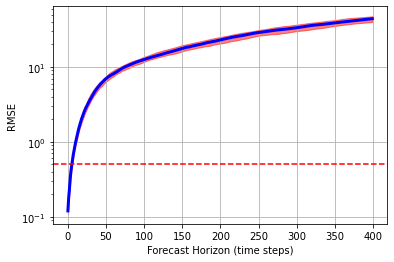

It takes around t = 1.50 for mean error to exceed 0.5


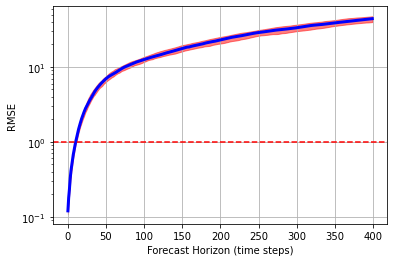

It takes around t = 2.75 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 2.345
Median NRMSE at t = 0.5: 6.974
Median NRMSE at t = 1: 12.561
Median NRMSE at t = 2: 22.953
Median NRMSE at t = 3: 33.341


In [46]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.3 L_forecast_train = 4, L_past = 8

In [47]:
L_forecast_train = 4; L_past = 8

In [48]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 2.39 | Train loss = 0.0113932 | Val loss =  3489.9682617
Epoch 20: Time taken = 2.21 | Train loss = 0.0034834 | Val loss =  620.7359009
Epoch 30: Time taken = 2.18 | Train loss = 0.0013739 | Val loss =  101.2369003
Epoch 40: Time taken = 2.62 | Train loss = 0.0010120 | Val loss =  40.7855759
Epoch 50: Time taken = 2.59 | Train loss = 0.0008591 | Val loss =  26.3344994
Epoch 53: Time taken = 2.70 | Train loss = 0.0008219 | Val loss =  17.5216713
Epoch 58: Time taken = 2.56 | Train loss = 0.0007844 | Val loss =  15.1171722
Epoch 59: Time taken = 2.81 | Train loss = 0.0007435 | Val loss =  11.9159260
Epoch 60: Time taken = 2.72 | Train loss = 0.0007728 | Val loss =  13.9879227
Epoch 64: Time taken = 2.54 | Train loss = 0.0007273 | Val loss =  8.7284727
Epoch 68: Time taken = 2.34 | Train loss = 0.0007131 | Val loss =  5.0935659
Epoch 70: Time taken = 2.32 | Train loss = 0.0006924 | Val loss =  12.8571033
Epoch 72: Time taken = 2.18 | Train los

In [49]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_3_mu_preds.pkl")

Testing complete. Time taken: 0.41


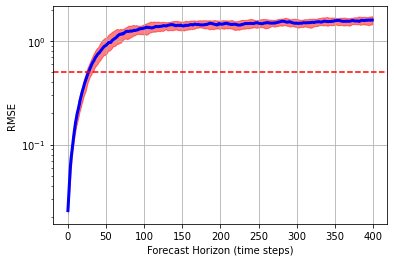

It takes around t = 6.75 for mean error to exceed 0.5


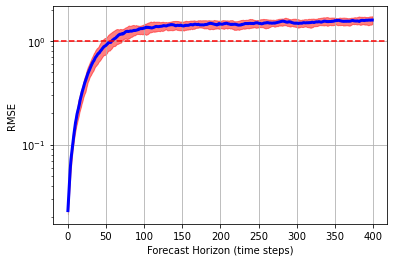

It takes around t = 14.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.346
Median NRMSE at t = 0.5: 0.906
Median NRMSE at t = 1: 1.328
Median NRMSE at t = 2: 1.455
Median NRMSE at t = 3: 1.480


In [50]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 L_forecast_train = 8, L_past = 1

In [51]:
L_forecast_train = 8; L_past = 1

In [52]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.63 | Train loss = 0.0090194 | Val loss =  1.6241831
Epoch 20: Time taken = 1.62 | Train loss = 0.0048318 | Val loss =  1.6071993
Epoch 30: Time taken = 1.72 | Train loss = 0.0032484 | Val loss =  1.6217290
Epoch 40: Time taken = 1.69 | Train loss = 0.0026357 | Val loss =  1.7764179
Epoch 50: Time taken = 1.69 | Train loss = 0.0021924 | Val loss =  1.6964574
Epoch 60: Time taken = 1.70 | Train loss = 0.0018688 | Val loss =  1.6845213
Epoch 70: Time taken = 1.64 | Train loss = 0.0017640 | Val loss =  1.6862171
Epoch 80: Time taken = 1.63 | Train loss = 0.0015735 | Val loss =  1.6938400
Epoch 90: Time taken = 1.64 | Train loss = 0.0014019 | Val loss =  1.6383663
Epoch 100: Time taken = 1.68 | Train loss = 0.0013929 | Val loss =  1.6698939
Epoch 110: Time taken = 1.71 | Train loss = 0.0013117 | Val loss =  1.6378206
Epoch 120: Time taken = 1.68 | Train loss = 0.0012314 | Val loss =  1.6960770
Epoch 130: Time taken = 1.63 | Train loss = 0.0011

In [53]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 0.45


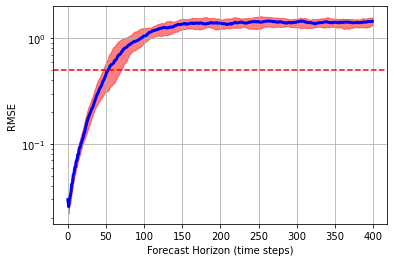

It takes around t = 13.25 for mean error to exceed 0.5


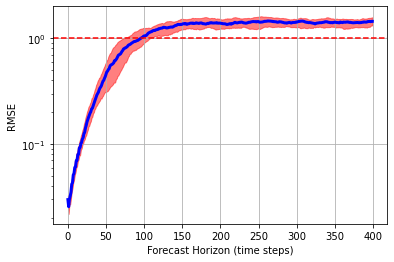

It takes around t = 24.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.115
Median NRMSE at t = 0.5: 0.456
Median NRMSE at t = 1: 1.049
Median NRMSE at t = 2: 1.384
Median NRMSE at t = 3: 1.416


In [54]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 L_forecast_train = 8, L_past = 4

In [55]:
L_forecast_train = 8; L_past = 4

In [56]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.99 | Train loss = 0.0198954 | Val loss =  726.6336670
Epoch 20: Time taken = 2.05 | Train loss = 0.0052306 | Val loss =  64.9997864
Epoch 30: Time taken = 2.11 | Train loss = 0.0033720 | Val loss =  14.2951374
Epoch 40: Time taken = 2.13 | Train loss = 0.0027070 | Val loss =  9.8063679
Epoch 50: Time taken = 2.11 | Train loss = 0.0022904 | Val loss =  2.5149252
Epoch 52: Time taken = 2.15 | Train loss = 0.0022092 | Val loss =  1.7260225
Epoch 58: Time taken = 2.09 | Train loss = 0.0021367 | Val loss =  1.6834009
Epoch 59: Time taken = 2.06 | Train loss = 0.0021332 | Val loss =  1.6760229
Epoch 60: Time taken = 2.16 | Train loss = 0.0020381 | Val loss =  1.7249429
Epoch 64: Time taken = 2.03 | Train loss = 0.0020015 | Val loss =  1.6636859
Epoch 70: Time taken = 2.08 | Train loss = 0.0019457 | Val loss =  1.6836710
Epoch 77: Time taken = 2.11 | Train loss = 0.0017896 | Val loss =  1.6621886
Epoch 80: Time taken = 2.03 | Train loss = 0.0017

In [57]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_5_mu_preds.pkl")

Testing complete. Time taken: 0.43


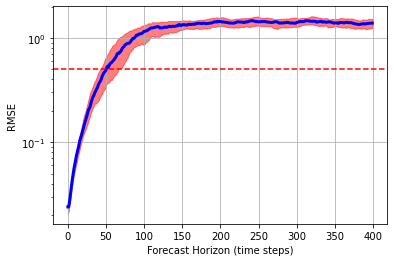

It takes around t = 12.75 for mean error to exceed 0.5


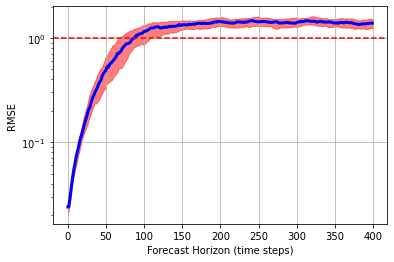

It takes around t = 22.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.134
Median NRMSE at t = 0.5: 0.496
Median NRMSE at t = 1: 1.159
Median NRMSE at t = 2: 1.439
Median NRMSE at t = 3: 1.411


In [58]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.6 L_forecast_train = 8, L_past = 8

In [59]:
L_forecast_train = 8; L_past = 8

In [60]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 2.59 | Train loss = 0.0125605 | Val loss =  55.7524376
Epoch 20: Time taken = 2.52 | Train loss = 0.0036846 | Val loss =  3.7311475
Epoch 30: Time taken = 2.47 | Train loss = 0.0026397 | Val loss =  1.7119704
Epoch 40: Time taken = 2.53 | Train loss = 0.0021193 | Val loss =  1.6535028
Epoch 50: Time taken = 2.54 | Train loss = 0.0018202 | Val loss =  1.6635646
Epoch 53: Time taken = 2.61 | Train loss = 0.0018231 | Val loss =  1.6456841
Epoch 59: Time taken = 2.49 | Train loss = 0.0016927 | Val loss =  1.6364225
Epoch 60: Time taken = 2.54 | Train loss = 0.0016486 | Val loss =  1.6551213
Epoch 63: Time taken = 2.58 | Train loss = 0.0016693 | Val loss =  1.6355227
Epoch 70: Time taken = 2.53 | Train loss = 0.0016502 | Val loss =  1.6319469
Epoch 77: Time taken = 2.44 | Train loss = 0.0015191 | Val loss =  1.6309826
Epoch 79: Time taken = 2.54 | Train loss = 0.0014833 | Val loss =  1.6223942
Epoch 80: Time taken = 2.51 | Train loss = 0.0015053

In [61]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_6_mu_preds.pkl")

Testing complete. Time taken: 0.46


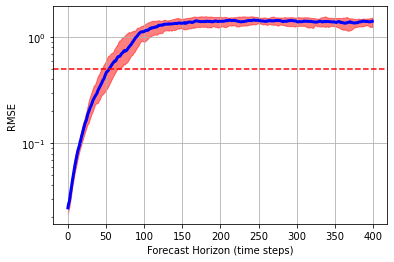

It takes around t = 13.75 for mean error to exceed 0.5


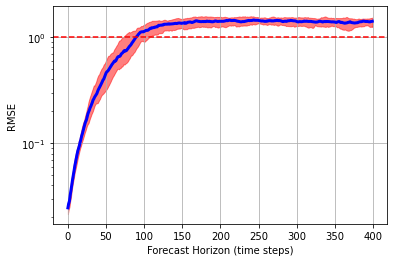

It takes around t = 22.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.132
Median NRMSE at t = 0.5: 0.459
Median NRMSE at t = 1: 1.131
Median NRMSE at t = 2: 1.406
Median NRMSE at t = 3: 1.401


In [62]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.7 L_forecast_train = 16, L_past = 1

In [63]:
L_forecast_train = 16; L_past = 1

In [64]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.00 | Train loss = 0.0646224 | Val loss =  45.9279480
Epoch 20: Time taken = 2.56 | Train loss = 0.0146172 | Val loss =  1.5704147
Epoch 30: Time taken = 3.09 | Train loss = 0.0093829 | Val loss =  1.6351219
Epoch 40: Time taken = 3.18 | Train loss = 0.0072433 | Val loss =  1.5932811
Epoch 50: Time taken = 3.17 | Train loss = 0.0062470 | Val loss =  1.5936606
Epoch 60: Time taken = 3.10 | Train loss = 0.0055746 | Val loss =  1.7260376
Epoch 70: Time taken = 2.63 | Train loss = 0.0047811 | Val loss =  1.6121080
Epoch 80: Time taken = 3.15 | Train loss = 0.0046775 | Val loss =  1.6522537
Epoch 90: Time taken = 3.25 | Train loss = 0.0042244 | Val loss =  1.6091541
Epoch 100: Time taken = 2.88 | Train loss = 0.0046011 | Val loss =  1.6418270
Epoch 110: Time taken = 2.86 | Train loss = 0.0036736 | Val loss =  1.6212909
Epoch 120: Time taken = 2.83 | Train loss = 0.0037662 | Val loss =  1.5982127
Epoch 130: Time taken = 2.68 | Train loss = 0.003

In [65]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_7_mu_preds.pkl")

Testing complete. Time taken: 0.39


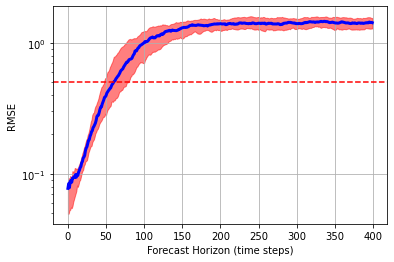

It takes around t = 15.00 for mean error to exceed 0.5


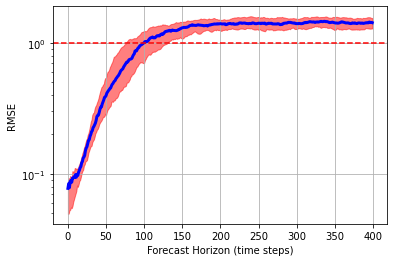

It takes around t = 25.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.132
Median NRMSE at t = 0.5: 0.395
Median NRMSE at t = 1: 1.003
Median NRMSE at t = 2: 1.402
Median NRMSE at t = 3: 1.403


In [66]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.8 L_forecast_train = 16, L_past = 4

In [67]:
L_forecast_train = 16; L_past = 4

In [68]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.20 | Train loss = 0.2129547 | Val loss =  709.9815063
Epoch 20: Time taken = 3.22 | Train loss = 0.0583685 | Val loss =  64.4920578
Epoch 30: Time taken = 3.29 | Train loss = 0.0252235 | Val loss =  9.4507504
Epoch 40: Time taken = 3.24 | Train loss = 0.0254473 | Val loss =  2.5568254
Epoch 50: Time taken = 3.28 | Train loss = 0.0429771 | Val loss =  31.8995228
Epoch 60: Time taken = 2.98 | Train loss = 0.0212796 | Val loss =  2.4321852
Epoch 70: Time taken = 3.27 | Train loss = 0.0218809 | Val loss =  12.8829098
Epoch 80: Time taken = 3.47 | Train loss = 0.0231038 | Val loss =  19.5655441
Epoch 90: Time taken = 3.49 | Train loss = 0.0301284 | Val loss =  18.0289993
Epoch 100: Time taken = 3.41 | Train loss = 0.0188777 | Val loss =  57.9946060
Epoch 110: Time taken = 3.20 | Train loss = 0.0233332 | Val loss =  49.0989952
Epoch 120: Time taken = 3.23 | Train loss = 0.0238145 | Val loss =  20.9187908
Epoch 130: Time taken = 3.22 | Train los

In [70]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_8_mu_preds.pkl")

Testing complete. Time taken: 0.48


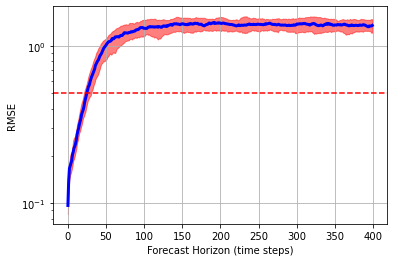

It takes around t = 6.25 for mean error to exceed 0.5


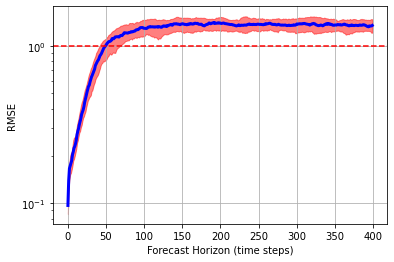

It takes around t = 12.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.392
Median NRMSE at t = 0.5: 1.010
Median NRMSE at t = 1: 1.294
Median NRMSE at t = 2: 1.393
Median NRMSE at t = 3: 1.377


In [71]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.9 L_forecast_train = 16, L_past = 8

In [123]:
L_forecast_train = 16; L_past = 8

In [124]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.87 | Train loss = 0.1319703 | Val loss =  327.8346252
Epoch 20: Time taken = 3.81 | Train loss = 0.0367912 | Val loss =  5.1814241
Epoch 30: Time taken = 3.81 | Train loss = 0.0176174 | Val loss =  1.6263915
Epoch 40: Time taken = 3.86 | Train loss = 0.0121306 | Val loss =  1.6145744
Epoch 50: Time taken = 3.85 | Train loss = 0.0224016 | Val loss =  1.6329637
Epoch 60: Time taken = 3.96 | Train loss = 0.0189999 | Val loss =  2.5695252
Epoch 70: Time taken = 3.82 | Train loss = 0.0370426 | Val loss =  6.7156081
Epoch 80: Time taken = 3.85 | Train loss = 0.0425533 | Val loss =  59.6169319
Epoch 90: Time taken = 3.84 | Train loss = 0.0234140 | Val loss =  78.3921738
Epoch 100: Time taken = 3.76 | Train loss = 0.0505779 | Val loss =  43.9863167
Epoch 110: Time taken = 3.91 | Train loss = 0.0224333 | Val loss =  55.8869667
Epoch 120: Time taken = 3.85 | Train loss = 0.0178441 | Val loss =  30.4382305
Epoch 130: Time taken = 3.90 | Train loss =

In [125]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_2_9_mu_preds.pkl")

Testing complete. Time taken: 0.39


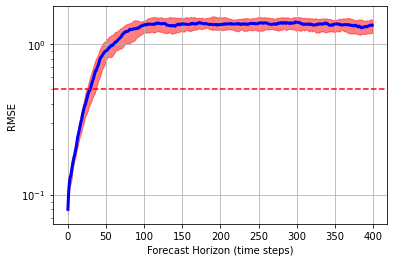

It takes around t = 7.50 for mean error to exceed 0.5


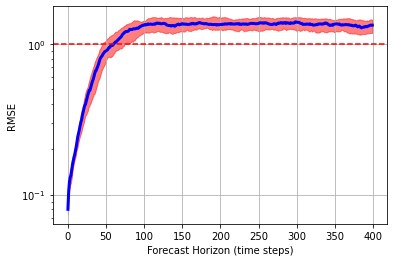

It takes around t = 15.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.355
Median NRMSE at t = 0.5: 0.900
Median NRMSE at t = 1: 1.340
Median NRMSE at t = 2: 1.348
Median NRMSE at t = 3: 1.396


In [126]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best Model

nn_size = 1000  
L_forecast_train = 8  
L_past = 4

In [127]:
nn_size = 500
L_forecast_train = 16
L_past = 1

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [500, 200, 200]  # Number of epochs for each learning rate

In [128]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 100)

Backpropogation start

Epoch 10: Time taken = 2.77 | Train loss = 0.0646224 | Val loss =  45.9279480
Epoch 20: Time taken = 2.84 | Train loss = 0.0146172 | Val loss =  1.5704147
Epoch 30: Time taken = 2.74 | Train loss = 0.0093829 | Val loss =  1.6351219
Epoch 40: Time taken = 2.78 | Train loss = 0.0072433 | Val loss =  1.5932811
Epoch 50: Time taken = 2.70 | Train loss = 0.0062470 | Val loss =  1.5936606
Epoch 60: Time taken = 2.93 | Train loss = 0.0055746 | Val loss =  1.7260376
Epoch 70: Time taken = 2.89 | Train loss = 0.0047811 | Val loss =  1.6121080
Epoch 80: Time taken = 2.97 | Train loss = 0.0046775 | Val loss =  1.6522537
Epoch 90: Time taken = 2.92 | Train loss = 0.0042244 | Val loss =  1.6091541
Epoch 100: Time taken = 2.97 | Train loss = 0.0046011 | Val loss =  1.6418270
Epoch 110: Time taken = 2.99 | Train loss = 0.0036736 | Val loss =  1.6212909
Epoch 120: Time taken = 2.95 | Train loss = 0.0037662 | Val loss =  1.5982127
Epoch 130: Time taken = 2.93 | Train loss = 0.003

In [129]:
mean_pred = get_test_pred(X_test, params, rnn_fx)

Testing complete. Time taken: 0.39


In [130]:
save_obj(params, "results/rnn", "best_params.pkl")
save_obj(mean_pred, "results/rnn", "best_mu_preds.pkl")

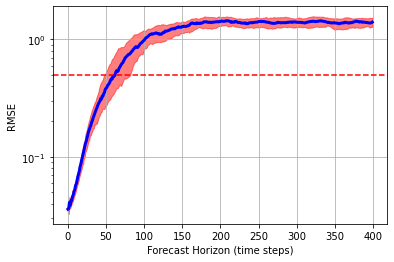

It takes around t = 15.50 for mean error to exceed 0.5


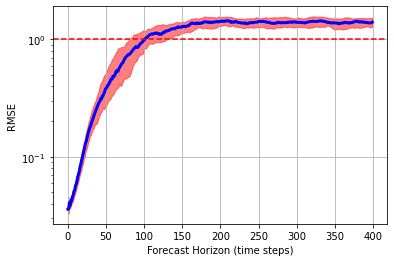

It takes around t = 25.25 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.106
Median NRMSE at t = 0.5: 0.384
Median NRMSE at t = 1: 0.987
Median NRMSE at t = 2: 1.421
Median NRMSE at t = 3: 1.401


In [131]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [12]:
nn_size = 500
_, process, forecast = RNN(nn_size, data_dim)       # RNN Network
process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)

In [13]:
params = load_obj("results/rnn/best_params.pkl")

In [14]:
mean_pred = get_test_pred(X_test, params, (process_batch, forecast_batch))
save_obj(mean_pred, "results", "rnn_pred.pkl")

Testing complete. Time taken: 1.72


In [9]:
mean_pred = load_obj("results/rnn_pred.pkl")

In [10]:
total_lyapunov_time_pred = 100 / KS_LT # Amount of Lyapunov Time in Test set

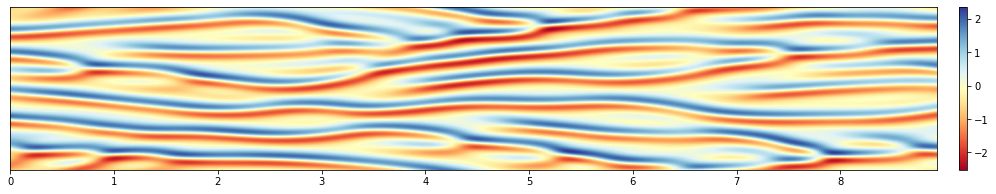

In [11]:
plt.figure(figsize = (20, 3))
plt.imshow(y_test[0].T, cmap = "RdYlBu", aspect = "auto", extent = [0, total_lyapunov_time_pred, 0, 40])
plt.tick_params(axis='both', which='both', left = False, labelleft = False,) 
plt.colorbar(pad = 0.02)
# plt.xlabel("Lyapunov Time")
# plt.title("Actual")
plt.savefig("ks_actual.png", facecolor = "white", bbox_inches = "tight")
plt.show()

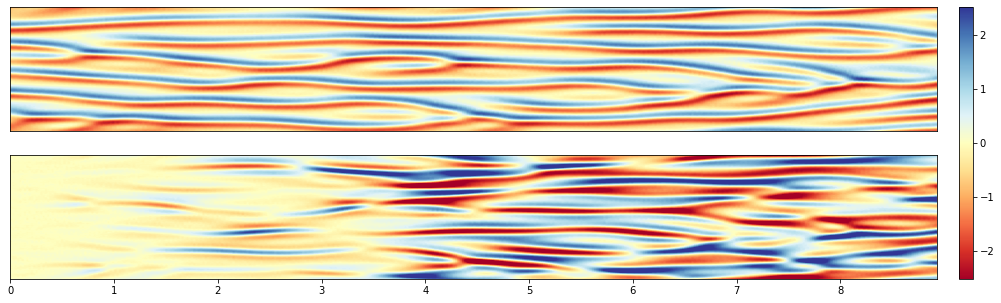

In [12]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "ks_rnn", pred_only=True)

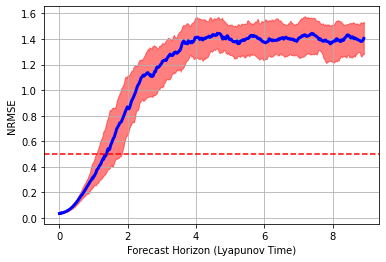

It takes around 1.38 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.120
Median NRMSE at 1.0 Lyapunov Time: 0.311
Median NRMSE at 2.0 Lyapunov Time: 0.869
Median NRMSE at 5.0 Lyapunov Time: 1.395


In [18]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "ks")
res_single.plot_rmse(save_name = "Figure3-2b_RNN_Prediction_Horizon")
print()
res_single.get_loss()